In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import trieste
from trieste.acquisition.optimizer import generate_continuous_optimizer
from trieste.acquisition.function.updated_constrained_thompson_sampling import UpdatedThompsonSamplingAugmentedLagrangian
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives

In [2]:
NUM_INITIAL_SAMPLES = 5
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
search_space = Box([0.0, 0.0], [1.0, 1.0])

In [3]:
def create_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr, num_rff_features=500)

In [ ]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(0.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(0.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/31-01-23/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

### Progression of Best Valid Point over Time

In [8]:
all_results = []
for run in range(20):
    with open(f"results/31-01-23/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    all_results.append(np.minimum.accumulate(safe_obs_values))
all_results = np.array(all_results)
all_results_mean = np.mean(all_results, axis=0)

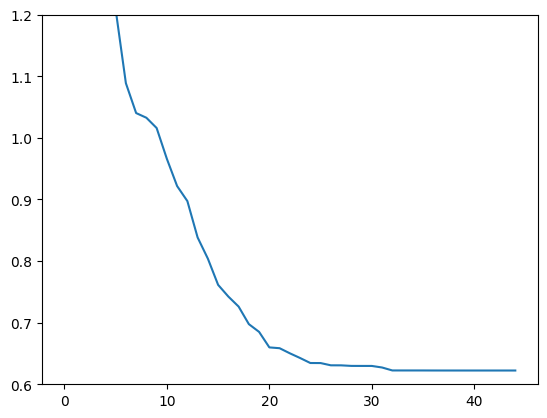

In [9]:
plt.plot(all_results_mean)
plt.ylim(0.6, 1.2)
plt.show()

### Plot Query Points on Objective

In [21]:
with open("results/31-01-23/run_16_data.pkl", "rb") as fp:
    data = pickle.load(fp)

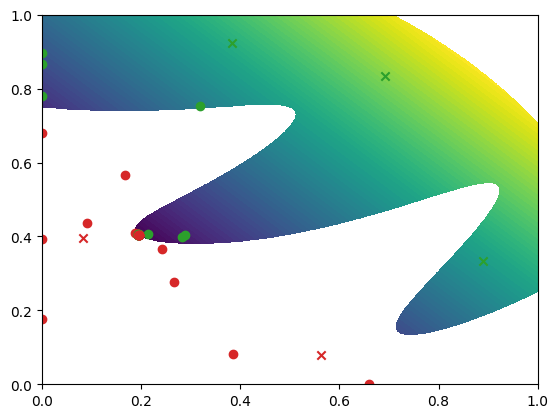

In [22]:
def masked_objective(x):
    mask_nan = np.logical_or(
        constraints.toy_constraint_one(x) > 0.0,
        constraints.toy_constraint_two(x) > 0.0,
    )
    y = np.array(objectives.linear_objective(x))
    y[mask_nan] = np.nan
    return tf.convert_to_tensor(y.reshape(-1, 1), x.dtype)


mask_fail1 = (
    data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().flatten() > 0
)
mask_fail2 = (
    data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().flatten() > 0
)
mask_fail = np.logical_or(mask_fail1, mask_fail2)

import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_function_2d, plot_bo_points

fig, ax = plot_function_2d(
    masked_objective,
    search_space.lower,
    search_space.upper,
    grid_density=1000,
    contour=True,
    fill=True,
)
plot_bo_points(
    data[OBJECTIVE].query_points.numpy(),
    ax=ax[0, 0],
    num_init=NUM_INITIAL_SAMPLES,
    mask_fail=mask_fail,
)
plt.show()